\begin{equation}
	\begin{aligned}
		V(x,\xi) \quad  = \quad \max_{y} \quad & U\big(x,y,\xi\big) + \beta \mathop{\mathbb{E}}\big[V\big(x',\xi'\big) \big| \xi] \\
		\textrm{s.t.} \quad & y \in \Gamma(x) \\
		\quad & x'=h(x,y,\xi)
	\end{aligned}
\end{equation}

In [1]:
using  Plots, LinearAlgebra, Optim, DataFrames, StatFiles, Distributions, Roots, Random, Interpolations, BenchmarkTools
using PGFPlotsX

In [2]:
function VFIWS(U, β, Γ, State_Range, Shock_Range, l, IG, Shock_function; R=10^3, Iter = 200)
                                                                                              
    Random.seed!(1401)
    S_G = range(State_Range[1], State_Range[2], l)
    Sh_G = range(Shock_Range[1], Shock_Range[2], l)
    V = IG #Initial Value function
    TV = zeros(l,l)
    P = zeros(l,l)
    sup = 1
    while (Iter>0)
        V0 = LinearInterpolation((S_G, Sh_G), V, extrapolation_bc=Line())
        Threads.@threads for j in 1:l
            rs = Shock_function(Sh_G[j], R)
            for i in 1:l
                Vh(y) = mean(V0(y, rs))
                Ω(y) = -(U(S_G[i], y, Sh_G[j]) + β*Vh(y))
                opt = optimize(Ω, Γ(S_G[i])[1], Γ(S_G[i])[2])
                P[i,j] = opt.minimizer 
                TV[i,j] = -Ω(P[i,j])
            end
        end
        V = copy(TV)
        Iter = Iter-1
    end
    return V, P
end

VFIWS (generic function with 1 method)

In [3]:
function ab_LogNormal(mu, sig)
    a(b) = log(mu)-b^2/2
    f(b) = sig^2 - (exp(b^2)-1)*(exp(2*a(b) + b^2))
    b_star = find_zero(f, sig)
    a_star = a(b_star)
    return a_star, b_star
end

ab_LogNormal (generic function with 1 method)

In [4]:
σ = 0.8
w = 1
β = 0.90
l = 50
r = 0.07
ur = 40
a, b = ab_LogNormal(1, 1)
Shock_function(s, l) = 0.7*s .+ 0.5*rand(LogNormal(a,b), l)
IG2 = zeros(l,l)
U(x,y,s) = ((1+r)*x + w*s - y)^(1-σ) / (1-σ)
Γ(x) = [10^-6, (1+r)*x]
State_Range = [10^-5,Γ(ur)[2]]
Shock_Range = [2,5]
Value_function, Policy_function = VFIWS(U, β, Γ, State_Range, Shock_Range, l, IG2, Shock_function; R=10^3, Iter = 200);

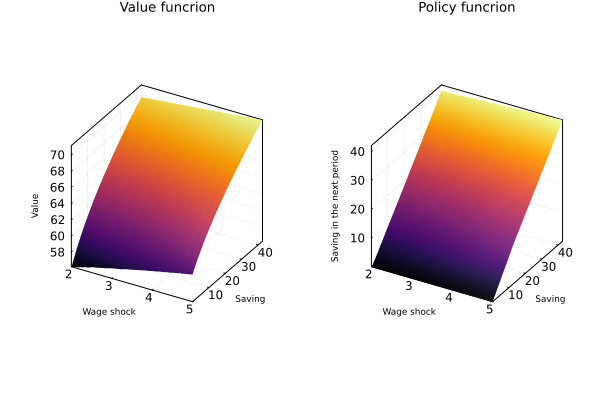

In [5]:
plots = []
xGrid = range(Shock_Range[1], Shock_Range[2], l)
yGrid = range(State_Range[1], State_Range[2], l)
p1 = surface(xGrid, yGrid, Value_function, xlabel="Wage shock", ylabel="Saving", zlabel = "Value", title = "Value funcrion", legend=false, titlefontsize=9, guidefontsize=6)
push!(plots,p1)
p2 = surface(xGrid, yGrid, Policy_function, xlabel="Wage shock", ylabel="Saving", zlabel = "Saving in the next period", title = "Policy funcrion", legend=false, titlefontsize=9, guidefontsize=6)
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)